In [ ]:
# You will need to download any word embeddings required for your code, e.g.:

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

# For any packages that Colab does not provide auotmatically you will also need to install these below, e.g.:

#! pip install torch

--2021-02-21 09:29:49--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-02-21 09:29:49--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-02-21 09:29:49--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.3’

glove

In [1]:
# Imports
import regex as re
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import codecs
from numpy import dot
from numpy.linalg import norm

In [2]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

/shared-libs/python3.7/py/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
def sanitize(df):
    """
    Sanitizes the original sentences using hand-crafted rules.
    """
    
    df['original'] = df['original'].str.replace('GOP', 'G.O.P.')
    df['original'] = df['original'].str.replace('US', 'U.S.')
    df['original'] = df['original'].str.replace('Sen\.', 'Senator')

    df['original'] = df['original'].str.replace("'re|’re", 'are')
    df['original'] = df['original'].str.replace("'m|’m", 'am')
    df['original'] = df['original'].str.replace("ca+\s+n’t|ca+\s+n't", 'cannot')
    df['original'] = df['original'].str.replace("n’t|n't", 'not')
    df['original'] = df['original'].str.replace("'ll|’ll", 'will')

    df['original'] = df['original'].str.replace("’+\s|‘+\s", '')
    df['original'] = df['original'].str.replace("'+\s|’+$|'+$", '')
    df['original'] = df['original'].str.replace("“|\"|”", '')
    df['original'] = df['original'].str.replace(",", '')
    df['original'] = df['original'].str.replace(';', ':')

    df['original'] = df['original'].str.replace("@realDonaldTrump", 'Trump')

    outlets = "- BBC News|- BBC New|- Vox| - Los Angeles Times| - CNN Video|\
    - Salon.com|- Breitbart|- The New York Times| - New York Times| - NBC News |\
    - Politics live| -- live stream| -- live updates| - CNNPolitics.com|\
    - Business Insider|- NBC News| - Global Witness"
    df['original'] = df['original'].str.replace(outlets, '')

    return df

In [4]:
# Load data
train_df = pd.read_csv('/work/NLP_cwk/competition_data/task-1/train.csv')
dev_df = pd.read_csv('/work/NLP_cwk/competition_data/task-1/dev.csv')
test_df = pd.read_csv('/work/NLP_cwk/competition_data/task-1/test.csv')

#Clean the data
train_df = sanitize(train_df)
dev_df = sanitize(dev_df)
test_df = sanitize(test_df)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  if sys.path[0] == '':
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from Tr

In [5]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """
    train_RMSEs = []
    val_RMSEs = []

    print("Training model.")

    for epoch in range(1, number_epoch+1):

        model.train()
        epoch_loss = 0
        epoch_sse = 0
        no_observations = 0  # Observations used for training so far

        for batch in train_iter:

            original_feature, edited_feature, original_mask, edit_mask, target = batch

            original_feature, edited_feature, original_mask, edit_mask, target = original_feature.to(device), edited_feature.to(device), original_mask.to(device), edit_mask.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.original_hidden = model.init_hidden()
            model.edited_hidden = model.init_hidden()

            predictions = model(original_feature, edited_feature, original_mask, edit_mask).squeeze(1)

            optimizer.zero_grad()

            loss = loss_fn(predictions, target)

            sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse

        valid_loss, valid_mse, __, __ = eval(dev_iter, model)

        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations

        train_RMSEs.append(epoch_mse**0.5)
        val_RMSEs.append(valid_mse**0.5)

        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')

    return train_RMSEs, val_RMSEs

In [6]:
# We evaluate performance on our dev set
def eval(data_iter, model):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    pred_all = []
    trg_all = []
    no_observations = 0

    with torch.no_grad():
        for batch in data_iter:
            original_feature, edited_feature, original_mask, edit_mask, target = batch

            original_feature, edited_feature, original_mask, edit_mask, target = original_feature.to(device), edited_feature.to(device), original_mask.to(device), edit_mask.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.original_hidden = model.init_hidden()
            model.edited_hidden = model.init_hidden()

            predictions = model(original_feature, edited_feature, original_mask, edit_mask).squeeze(1)
            loss = loss_fn(predictions, target)

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [7]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

In [8]:
def create_vocab(original_data, edit_words):
    """
    Creating one corpus of all the tokens used in the original sentences
    and one of all the tokens used in the edited sentences. Also keep the
    original words in a list (We'll need them later).
    """
    original_tokenized_corpus = [] 
    edited_tokenized_corpus = []
    original_words = []
    for i in range(len(original_data)):
        sentence = original_data[i]
        edit_word = edit_words[i]

        old_words = re.findall("<(.*)/>", sentence)[0].split(' ')

        original_tokenized_sentence = []
        edited_tokenized_sentence = []

        for token in re.split(' |<|/>',sentence): # simplest split is
            original_tokenized_sentence.append(token.lower())
            if(old_words[-1] == token):
                edited_tokenized_sentence.append(edit_word.lower())
            if(token not in old_words):
                edited_tokenized_sentence.append(token.lower())

        original_tokenized_corpus.append(original_tokenized_sentence)
        edited_tokenized_corpus.append(edited_tokenized_sentence)
        original_words.append(old_words)


    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence in original_tokenized_corpus:

        for token in sentence:

            if token not in vocabulary:

                if True:
                    vocabulary.append(token)

    for word in edit_words:
        if(word.lower() not in vocabulary):
            if True:
                    vocabulary.append(word.lower())

    return vocabulary, original_tokenized_corpus, edited_tokenized_corpus, original_words

In [9]:
def collate_fn_padd(batch):
    '''
    We add padding to our minibatches so all the tensors 
    in one batch have the same length and create tensors for our model
    '''

    batch_original_mask = [o_m for _, _, o_m, _, _ in batch]
    batch_edit_mask = [e_m for _, _, _, e_m, _ in batch]
    batch_labels = [l for _, _, _, _, l in batch]
    batch_original_features = [o_f for o_f, _, _, _, _ in batch]
    batch_edited_features = [e_f for _, e_f, _, _, _ in batch]

    #Edit and original sentences may differ in length if more than one word replaced
    batch_original_features_len = [len(o_f) for o_f, _, _, _, _ in batch]
    batch_edit_features_len = [len(e_f) for _, e_f, _, _, _ in batch]

    if(max(batch_original_features_len) > max(batch_edit_features_len)):
        max_len = max(batch_original_features_len)
    else:
        max_len = max(batch_edit_features_len)

    original_seq_tensor = torch.zeros((len(batch), max_len)).long()
    edited_seq_tensor = torch.zeros((len(batch), max_len)).long()
    original_mask_tensor = torch.zeros((len(batch), max_len)).long()
    edit_mask_tensor = torch.zeros((len(batch), max_len)).long()

    for idx, (seq, seqlen) in enumerate(zip(batch_original_features, batch_original_features_len)):
        original_seq_tensor[idx, :seqlen] = torch.LongTensor(seq)
    
    for idx, (seq, seqlen) in enumerate(zip(batch_edited_features, batch_edit_features_len)):
        edited_seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

    for idx, (mask, seqlen) in enumerate(zip(batch_original_mask, batch_original_features_len)):
        original_mask_tensor[idx, :seqlen] = torch.LongTensor(mask)

    for idx, (mask, seqlen) in enumerate(zip(batch_edit_mask, batch_edit_features_len)):
        edit_mask_tensor[idx, :seqlen] = torch.LongTensor(mask)

    batch_labels = torch.FloatTensor(batch_labels)

    return original_seq_tensor, edited_seq_tensor, original_mask_tensor, edit_mask_tensor, batch_labels

class Task1Dataset(Dataset):

    def __init__(self, original_train_data, edited_train_data, original_indices, edit_indices, labels):
        self.x_train_original = original_train_data
        self.x_train_edited = edited_train_data
        self.y_train = labels
        self.original_indices = original_indices
        self.edit_indices = edit_indices

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        #masks to select the hidden states corresponing to the original subsentence
        #and the replacemenent word
        original_mask = torch.zeros(len(self.x_train_original[item])).long()
        original_mask[self.original_indices[item]] = 1

        edit_mask = torch.zeros(len(self.x_train_edited[item])).long()
        edit_mask[self.edit_indices[item]] = 1

        return self.x_train_original[item], self.x_train_edited[item], original_mask, edit_mask, self.y_train[item]

In [10]:
class BiLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, device):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        #Sub-network to extract the representation of the original subsentence
        self.original_lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, dropout = 0.5)
        #Sub-network to extract the representation of the edited subsentence
        self.edited_lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, dropout = 0.5)

        self.original_hidden = self.init_hidden()
        self.edited_hidden = self.init_hidden()

        #Cosine distance to funninness
        self.dissim2hidden = nn.Linear(1,5)
        self.hidden2label = nn.Linear(5,1)

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), \
               torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

    def forward(self, original_sentence, edited_sentence, original_mask, edit_mask):
        #Create embedding for the original and edited sentences
        original_embedded = self.embedding(original_sentence)
        original_embedded = original_embedded.permute(1, 0, 2)

        edited_embedded = self.embedding(edited_sentence)
        edited_embedded = edited_embedded.permute(1, 0, 2)

        #Get the hidden states of the original and edited sentences
        original_lstm_out, self.original_hidden = self.original_lstm(
            original_embedded.view(len(original_embedded), self.batch_size, self.embedding_dim), self.original_hidden)

        edited_lstm_out, self.edited_hidden = self.edited_lstm(
            edited_embedded.view(len(edited_embedded), self.batch_size, self.embedding_dim), self.edited_hidden)
        
        original_mask = original_mask.transpose(0,1).unsqueeze(-1)
        edit_mask = edit_mask.transpose(0,1).unsqueeze(-1)

        #Extract the hidden states corresponding to the original and edit words
        original_lstm_out = original_lstm_out*original_mask
        edited_lstm_out = edited_lstm_out*edit_mask

        #Average over these states(original words may be more than one)
        original_lstm_out = original_lstm_out.sum(0)
        edited_lstm_out = edited_lstm_out.sum(0)

        original_lstm_out = original_lstm_out.div(original_mask.sum(0))
        edited_lstm_out = edited_lstm_out.div(edit_mask.sum(0))

        #Calculate a cosine distance between the two representations
        cos_dist = 1 - torch.sum(original_lstm_out*edited_lstm_out, dim = 1)/(torch.norm(original_lstm_out, dim =1 )*torch.norm(edited_lstm_out, dim =1))
        cos_dist = cos_dist.unsqueeze(-1)

        #Map this distance to a similarity score
        out = F.relu(self.dissim2hidden(cos_dist))
        out = self.hidden2label(out)

        return out


In [11]:
## Approach 1 code, using functions defined above:

# We set our training, dev and test data
train_original_data = train_df['original']
train_edit_words = train_df['edit']
dev_original_data = dev_df['original']
dev_edit_words = dev_df['edit']
test_original_data = test_df['original']
test_edit_words = test_df['edit']

# Creating vocabulary, tokenizing the corpuses and storing the original words
training_vocab, \
  training_original_tokenized_corpus, \
  training_edited_tokenized_corpus, \
  training_original_words = \
    create_vocab(train_original_data, train_edit_words)

dev_vocab, \
  dev_original_tokenized_corpus, \
  dev_edited_tokenized_corpus, \
  dev_original_words = \
    create_vocab(dev_original_data, dev_edit_words)
    
test_vocab, \
  test_original_tokenized_corpus, \
  test_edited_tokenized_corpus, \
  test_original_words \
    = create_vocab(test_original_data, test_edit_words)

# Creating joint vocab from test and train:
joint_vocab, \
  joint_original_tokenized_corpus, \
  joint_edited_tokenized_corpus, \
  joint_original_words = create_vocab(
  pd.concat([train_original_data, dev_original_data], ignore_index= True), 
  pd.concat([train_edit_words, dev_edit_words], ignore_index= True))
print("Vocab created.")

Vocab created.


In [12]:
# We create representations for our tokens
wvecs = [] # word vectors
word2idx = [] # word2index
idx2word = []

# This is a large file, it will take a while to load in the memory!
with codecs.open('glove.6B.100d.txt', 'r','utf-8') as f:
  index = 1
  for line in f.readlines():
    # Ignore the first line - first line typically contains vocab, dimensionality
    if len(line.strip().split()) > 3:
      word = line.strip().split()[0]
      if word in joint_vocab:
          (word, vec) = (word,
                     list(map(float,line.strip().split()[1:])))
          wvecs.append(vec)
          word2idx.append((word, index))
          idx2word.append((index, word))
          index += 1

word2idx.append(('<pad>', 0))
idx2word.append((0, '<pad>'))
wvecs = np.insert(wvecs, 0, 0., axis=0)
wvecs = np.array(wvecs)
word2idx = dict(word2idx)
idx2word = dict(idx2word)

#Create vectorized sequences of the original and edited sentences
training_original_vectorized_seqs = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in training_original_tokenized_corpus]
training_edited_vectorized_seqs = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in training_edited_tokenized_corpus]

dev_original_vectorized_seqs = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in dev_original_tokenized_corpus]
dev_edited_vectorized_seqs = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in dev_edited_tokenized_corpus]

testing_original_vectorized_seqs = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in test_original_tokenized_corpus]
testing_edited_vectorized_seqs = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in test_edited_tokenized_corpus]

# To avoid any sentences being empty (if no words match to our word embeddings)
training_original_vectorized_seqs = [x if len(x) > 0 else [0] for x in training_original_vectorized_seqs]
training_edited_vectorized_seqs = [x if len(x) > 0 else [0] for x in training_edited_vectorized_seqs]

dev_original_vectorized_seqs = [x if len(x) > 0 else [0] for x in dev_original_vectorized_seqs]
dev_edited_vectorized_seqs = [x if len(x) > 0 else [0] for x in dev_edited_vectorized_seqs]

testing_original_vectorized_seqs = [x if len(x) > 0 else [0] for x in testing_original_vectorized_seqs]
testing_edited_vectorized_seqs = [x if len(x) > 0 else [0] for x in testing_edited_vectorized_seqs]

In [13]:
'''
Find the position of the original and edited words in the vectorized sequences
We do that using that here and not before because words might be removed during
the vectorizing procedure above
'''
training_corpus_original_indices = []
training_corpus_edit_indices = []
dev_corpus_original_indices = []
dev_corpus_edit_indices = []
testing_corpus_original_indices = []
testing_corpus_edit_indices = []

for i in range(len(training_original_vectorized_seqs)):
    sentence_original_indices = []
    seq = [idx2word[index] for index in training_original_vectorized_seqs[i]]
    for word in training_original_words[i]:
        if(word.lower() in seq):
            sentence_original_indices.append(seq.index(word.lower()))
    if not sentence_original_indices:
        sentence_original_indices.append(-1)
    training_corpus_original_indices.append(sentence_original_indices)

for i in range(len(training_original_vectorized_seqs)):
    sentence_edit_indices = []
    seq = [idx2word[index] for index in training_edited_vectorized_seqs[i]]
    if(train_edit_words[i].lower() in seq):
        sentence_edit_indices.append(seq.index(train_edit_words[i].lower()))
    if not sentence_edit_indices:
        sentence_edit_indices.append(-1)
    training_corpus_edit_indices.append(sentence_edit_indices)

for i in range(len(dev_original_vectorized_seqs)):
    sentence_original_indices = []
    seq = [idx2word[index] for index in dev_original_vectorized_seqs[i]]
    for word in dev_original_words[i]:
        if(word.lower() in seq):
            sentence_original_indices.append(seq.index(word.lower()))
    if not sentence_original_indices:
        sentence_original_indices.append(-1)
    dev_corpus_original_indices.append(sentence_original_indices)

for i in range(len(dev_original_vectorized_seqs)):
    sentence_edit_indices = []
    seq = [idx2word[index] for index in dev_edited_vectorized_seqs[i]]
    if(dev_edit_words[i].lower() in seq):
        sentence_edit_indices.append(seq.index(dev_edit_words[i].lower()))
    if not sentence_edit_indices:
        sentence_edit_indices.append(-1)
    dev_corpus_edit_indices.append(sentence_edit_indices)

for i in range(len(testing_original_vectorized_seqs)):
    sentence_original_indices = []
    seq = [idx2word[index] for index in testing_original_vectorized_seqs[i]]
    for word in test_original_words[i]:
        if(word.lower() in seq):
            sentence_original_indices.append(seq.index(word.lower()))
    if not sentence_original_indices:
        sentence_original_indices.append(-1)
    testing_corpus_original_indices.append(sentence_original_indices)

for i in range(len(testing_original_vectorized_seqs)):
    sentence_edit_indices = []
    seq = [idx2word[index] for index in testing_edited_vectorized_seqs[i]]
    if(test_edit_words[i].lower() in seq):
        sentence_edit_indices.append(seq.index(test_edit_words[i].lower()))
    if not sentence_edit_indices:
        sentence_edit_indices.append(-1)
    testing_corpus_edit_indices.append(sentence_edit_indices)

In [14]:
INPUT_DIM = len(word2idx)
EMBEDDING_DIM = 100
BATCH_SIZE = 32
HIDDEN_DIM = 64

model = BiLSTM(EMBEDDING_DIM, HIDDEN_DIM, INPUT_DIM, BATCH_SIZE, device)
print("Model initialised.")

model.to(device)
# We provide the model with our embeddings and freeze them
model.embedding.weight.data.copy_(torch.from_numpy(wvecs))
model.embedding.weight.requires_grad = False

training_original_feature = training_original_vectorized_seqs
training_edited_feature = training_edited_vectorized_seqs

dev_original_feature = dev_original_vectorized_seqs
dev_edited_feature = dev_edited_vectorized_seqs

testing_original_feature = testing_original_vectorized_seqs
testing_edited_feature = testing_edited_vectorized_seqs

train_dataset = Task1Dataset(
    training_original_feature,
    training_edited_feature,
    training_corpus_original_indices, 
    training_corpus_edit_indices, 
    train_df['meanGrade'])

dev_dataset = Task1Dataset(
    dev_original_feature,
    dev_edited_feature,
    dev_corpus_original_indices, 
    dev_corpus_edit_indices, 
    dev_df['meanGrade'])

test_dataset = Task1Dataset(
    testing_original_feature,
    testing_edited_feature,
    testing_corpus_original_indices, 
    testing_corpus_edit_indices, 
    test_df['meanGrade'])

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

Model initialised.
Dataloaders created.
/shared-libs/python3.7/py/lib/python3.7/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [15]:
loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters())

train_RMSEs, val_RMSEs = train(train_loader, dev_loader, model, number_epoch = 5)

Training model.
| Epoch: 01 | Train Loss: 0.72 | Train MSE: 0.72 | Train RMSE: 0.85 |         Val. Loss: 0.41 | Val. MSE: 0.41 |  Val. RMSE: 0.64 |
| Epoch: 02 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.33 | Val. MSE: 0.33 |  Val. RMSE: 0.58 |
| Epoch: 03 | Train Loss: 0.33 | Train MSE: 0.33 | Train RMSE: 0.58 |         Val. Loss: 0.31 | Val. MSE: 0.31 |  Val. RMSE: 0.56 |
| Epoch: 04 | Train Loss: 0.31 | Train MSE: 0.31 | Train RMSE: 0.56 |         Val. Loss: 0.30 | Val. MSE: 0.30 |  Val. RMSE: 0.54 |
| Epoch: 05 | Train Loss: 0.29 | Train MSE: 0.29 | Train RMSE: 0.54 |         Val. Loss: 0.29 | Val. MSE: 0.29 |  Val. RMSE: 0.54 |


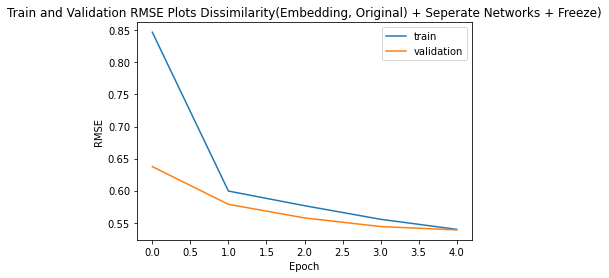

In [22]:
%matplotlib inline

plt.figure()
plt.plot(train_RMSEs, label = "train")
plt.plot(val_RMSEs, label = "validation")
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.title('Train and Validation RMSE Plots Dissimilarity(Embedding, Original) + Seperate Networks + Freeze)')
plt.legend()

plt.show()

Below we print the results of our model on the test set.

In [23]:
test_loss, test_mse, test_pred, test_target = eval(test_loader, model)
print("Test rmse is", test_mse**0.5)

Test rmse is 0.5510644105757196


# Post-training / Error Analysis

Text(0, 0.5, 'Prediction error')

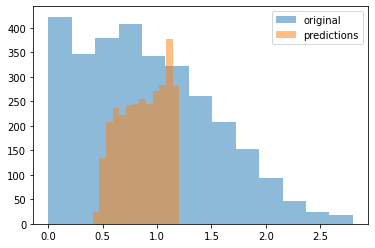

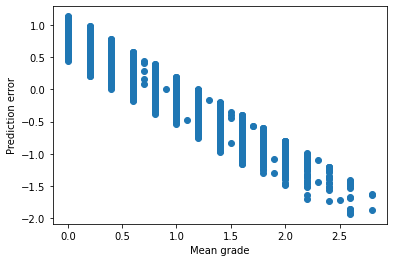

In [24]:
# We perform some error analysis on our predictions
# view model's output distribution of mean grade vs original distr.
_ = plt.hist(test_target, bins=13, alpha=0.5, label='original')
_ = plt.hist(test_pred, bins=13, alpha=0.5, label='predictions')
plt.legend()
# scatterplot between mean grade of input and error or absolute error
plt.figure()
_ = plt.scatter(test_target, test_pred - test_target)
plt.xlabel('Mean grade')
plt.ylabel('Prediction error')

In [25]:
# Top 10 least accurate predictions
residuals = np.abs(test_pred - test_target).ravel()
worse10 = np.argsort(residuals)[-10:]
print(test_pred[worse10])
test_df.loc[worse10]

[0.91475147 0.49239454 0.7729006  0.660147   0.74526554 0.7435932
 0.92964256 0.7063573  0.6804762  0.66229796]


,id,original,edit,grades,meanGrade
2685,1049,Becerra vows to fight pot <crackdown/> : They ...,heads,33322,2.6
453,7709,Moscow storm : 11 killed as high <winds/> stri...,stoners,33221,2.2
1345,12561,Scientists appeal for more people to <donate/>...,use,3333322222,2.5
109,9406,Man Sets Off Explosive Device at L.A.-Area Che...,complaints,33321,2.4
1368,11076,The Kremlin says Putin and Trump <agreed/> dur...,rapped,33331,2.6
2687,8162,Call Voter ID Laws What They Are - Attempts to...,Falsetto,33322,2.6
852,3409,CNN 's Jake Tapper to <interview/> Paul Ryan f...,wrestle,33332,2.8
423,2654,Secret <Service/> likely would not have interv...,Santa,33322,2.6
1081,13632,Jfk File : Fbi <Monitored/> Martin Luther King...,Enjoyed,33331,2.6
168,10836,Ben Shapiro : Americans more tolerant but hate...,meatloaf,33322,2.6


In [26]:
def lstm_score_funniness(model, original, edited, verbose=True):
    '''
    predict funninness score for unseen sentences
    '''
    original_words = []
    original_tokenized_corpus = [] 
    edited_tokenized_corpus = []
    original_tokenized_sentence = []
    edited_tokenized_sentence = []

    old_words = re.findall("<(.*)/>", original)[0].split(' ')

    #Create a corpus (just to add extra dimension) for the original and edit sentence
    for token in re.split(' |<|/>',original): 
            original_tokenized_sentence.append(token.lower())
            if(old_words[-1] == token):
                edited_tokenized_sentence.append(edited.lower())
            if(token not in old_words):
                edited_tokenized_sentence.append(token.lower())

    original_tokenized_corpus.append(original_tokenized_sentence)
    edited_tokenized_corpus.append(edited_tokenized_sentence)
    original_words.append(old_words)

    original_feature = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in original_tokenized_corpus]
    edited_feature = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in edited_tokenized_corpus]

    #find the position of the original subsentence and the edit word
    original_indices = []
    edited_indices = []
    for i in range(len(original_feature)):
        sentence_original_indices = []
        seq = [idx2word[index] for index in original_feature[i]]
        for word in original_words[i]:
            if(word.lower() in seq):
                sentence_original_indices.append(seq.index(word.lower()))
        if not sentence_original_indices:
            sentence_original_indices.append(-1)
        original_indices.append(sentence_original_indices)

    for i in range(len(edited_feature)):
        sentence_edit_indices = []
        seq = [idx2word[index] for index in edited_feature[i]]
        if(edited.lower() in seq):
            sentence_edit_indices.append(seq.index(edited.lower()))
        if not sentence_edit_indices:
            sentence_edit_indices.append(-1)
        edited_indices.append(sentence_edit_indices)

    #Prepare masks
    original_mask = torch.zeros(1,len(original_feature[0]))
    edit_mask = torch.zeros(1, len(edited_feature[0]))
    original_mask[0][original_indices] = 1
    edit_mask[0][edited_indices] = 1

    #Prepare feature
    original_feature = torch.tensor(np.array(original_feature))
    edited_feature = torch.tensor(np.array(edited_feature))

    #Make prediction
    model.eval()
    with torch.no_grad():
        predictions = model(original_feature, edited_feature, original_mask, edit_mask).squeeze(1)
    if verbose:
        print(f'Model\'s prediction: {predictions.item():.3f}\n')
    

In [27]:
model.batch_size = 1
model.original_hidden = model.init_hidden()
model.edited_hidden = model.init_hidden()
headline = 'New York prosecutors digging into Trump\'s <tax/>, financial records'
edited = 'nose'

_ = lstm_score_funniness(model, headline, edited)

Model's prediction: 0.943



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cd0ae3bf-8b9c-46ca-9eb4-5ef4b3522174' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>